# 1. Prepare

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import sys
import os
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns

#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from utils.log_progress import *
from utils.tools import *
from utils.config import *
from utils.utils import *

from unet.unet import *
from unet.data_generator import *

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

### Check if GPU available:

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Load Splited Data

In [5]:
train80_df = pd.read_pickle(Config.DATA_BASE_PATH+'/train_df')
val20_df = pd.read_pickle(Config.DATA_BASE_PATH+'/val_df')

print("Number of training Samples:", len(train80_df))
print("Number of validation Samples:", len(val20_df))

Number of training Samples: 405
Number of validation Samples: 102


In [6]:
train20_df = train80_df[0:102]
val80_df = val20_df.append(train80_df[102::])
print("Number of training Samples:", len(train20_df))
print("Number of validation Samples:", len(val80_df))

Number of training Samples: 102
Number of validation Samples: 405


In [7]:
mergedStuff = pd.merge(train80_df, train20_df, on=['name'], how='inner')
mergedStuff.head()

image_path_x            mask_path_x  \
0  ../data/00_all/images/  ../data/00_all/masks/   
1  ../data/00_all/images/  ../data/00_all/masks/   
2  ../data/00_all/images/  ../data/00_all/masks/   
3  ../data/00_all/images/  ../data/00_all/masks/   
4  ../data/00_all/images/  ../data/00_all/masks/   

              mask_cirlce_path_x          name dataset_x  \
0  ../data/00_all/masks_autogen/  img_1218.png      None   
1  ../data/00_all/masks_autogen/  img_1350.png      None   
2  ../data/00_all/masks_autogen/  img_1099.png      None   
3  ../data/00_all/masks_autogen/  img_1499.png      None   
4  ../data/00_all/masks_autogen/  img_1351.png      None   

                                          mask_rle_x  \
0  297273 1 298806 7 300340 12 301875 16 303409 1...   
1  895650 2 897181 1 897183 9 898713 16 899335 10...   
2  122363 2 123896 8 125423 3 125430 11 126956 22...   
3  527 21 1156 70 1261 276 2062 26 2692 72 2797 2...   
4  2026 57 2157 61 2286 157 3557 65 3691 63 3820 ...   

                                   mask_circle_rle_x  \
0  1071706 81 1076287 135 1080877 171 1085470 201...   
1  2083114 81 2087695 135 2092285 171 2096878 201...   
2  1117735 81 1122316 135 1126906 171 1131499 201...   
3  3523 861 8131 861 12739 861 17344 867 21952 86...   
4  1951 321 5875 81 6550 339 10456 135 11152 351 ...   

                                             roots_x  \
0  [[896.1610286707211, 385.9109855005754], [1174...   
1  [[972.309796698523, 906.7320856156502], [112.0...   
2          [[879.5127993049522, 395.36189275028767]]   
3  [[168.88437880104257, 786.5391134637514], [729...   
4  [[703.3204768027803, 144.69694453394703], [435...   

                                           splines_x            image_path_y  \
0  [[[895.0311589921805, 533.851117146145], [895....  ../data/00_all/images/   
1  [[[873.9948538662032, 1011.8286461495973], [91...  ../data/00_all/images/   
2  [[[545.5604211989574, 297.19178457997697], [57...  ../data/00_all/images/   
3  [[[44.828896194613385, 435.8123378596087], [55...  ../data/00_all/images/   
4  [[[170.03257549956555, 166.3862720368239], [23...  ../data/00_all/images/   

             mask_path_y             mask_cirlce_path_y dataset_y  \
0  ../data/00_all/masks/  ../data/00_all/masks_autogen/      None   
1  ../data/00_all/masks/  ../data/00_all/masks_autogen/      None   
2  ../data/00_all/masks/  ../data/00_all/masks_autogen/      None   
3  ../data/00_all/masks/  ../data/00_all/masks_autogen/      None   
4  ../data/00_all/masks/  ../data/00_all/masks_autogen/      None   

                                          mask_rle_y  \
0  297273 1 298806 7 300340 12 301875 16 303409 1...   
1  895650 2 897181 1 897183 9 898713 16 899335 10...   
2  122363 2 123896 8 125423 3 125430 11 126956 22...   
3  527 21 1156 70 1261 276 2062 26 2692 72 2797 2...   
4  2026 57 2157 61 2286 157 3557 65 3691 63 3820 ...   

                                   mask_circle_rle_y  \
0  1071706 81 1076287 135 1080877 171 1085470 201...   
1  2083114 81 2087695 135 2092285 171 2096878 201...   
2  1117735 81 1122316 135 1126906 171 1131499 201...   
3  3523 861 8131 861 12739 861 17344 867 21952 86...   
4  1951 321 5875 81 6550 339 10456 135 11152 351 ...   

                                             roots_y  \
0  [[896.1610286707211, 385.9109855005754], [1174...   
1  [[972.309796698523, 906.7320856156502], [112.0...   
2          [[879.5127993049522, 395.36189275028767]]   
3  [[168.88437880104257, 786.5391134637514], [729...   
4  [[703.3204768027803, 144.69694453394703], [435...   

                                           splines_y  
0  [[[895.0311589921805, 533.851117146145], [895....  
1  [[[873.9948538662032, 1011.8286461495973], [91...  
2  [[[545.5604211989574, 297.19178457997697], [57...  
3  [[[44.828896194613385, 435.8123378596087], [55...  
4  [[[170.03257549956555, 166.3862720368239], [23...

# 3 Training:

### 3.1 Load UNet Model:

#### Pretrained UNet:

model0 = model pretrained vgg19, trained both on leaf and root estimation mask

model1 = model pretrained vgg19, only trained on leaf mask

model2 = model pretrained vgg19, only trained on root estimation mask

```python
self.seq = iaa.Sequential([
            iaa.SomeOf((0, 4), [
                iaa.OneOf([
                    iaa.GaussianBlur(sigma=(0, 0.5)),
                    iaa.Sharpen(alpha=(0.0, 0.7)),
                ]),
                iaa.Fliplr(0.5, name="to_mask"),
                iaa.Flipud(0.5, name="to_mask"),
                #iaa.Crop(px=(0, 6), name="to_mask"),
                iaa.Affine(scale=(0.7,1.0),translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}, name="to_mask"),
            ]),
        ], random_order=True)
        self.seq_img = iaa.Sequential([
            iaa.Add((-60,60)),
        ])
        self.seq_norm = iaa.Sequential([
            iaa.CLAHE(),
            iaa.LinearContrast(alpha=1.0)
        ])
```



model10 = model pretrained vgg19, trained both on leaf and root estimation mask

```python
self.seq = iaa.Sequential([
            iaa.SomeOf((0, 4), [
                iaa.OneOf([
                    iaa.GaussianBlur(sigma=(0, 0.5)),
                    iaa.Sharpen(alpha=(0.0, 0.7)),
                ]),
                iaa.Fliplr(0.5, name="to_mask"),
                iaa.Flipud(0.5, name="to_mask"),
                #iaa.Crop(px=(0, 6), name="to_mask"),
                iaa.Affine(scale=(0.7,1.0),translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}, name="to_mask"),
            ]),
        ], random_order=True)
        self.seq_img = iaa.Sequential([
            iaa.Add((-20,20)),
        ])
        self.seq_norm = iaa.Sequential([
            iaa.CLAHE(),
            iaa.LinearContrast(alpha=1.0)
        ])
```


In [8]:
encoder_type = "vgg19"
unet = UNet()
unet.create_pretrained_model(encoder_type=encoder_type,batchnorm=False,coord_conv=False,input_shape=(512, 768, 3),num_classes=1)
model = unet.get_model()
unet.freeze_encoder(model,encoder_type)
model = unet.get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 768, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 768, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 384, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

### 3.2 Define Train- Generator:

In [9]:
params = {'target_size': Config.SHAPE,
          'batch_size': 4,
          'input_channels': 3,
          'shuffle': True,
          'output':"root"}

# Generators
sample_gen = DataGenerator(df=train80_df,hist_equal=True,augment_data=True,save_images=False,**params)
i_sample = iter(sample_gen)

Found 405 Files


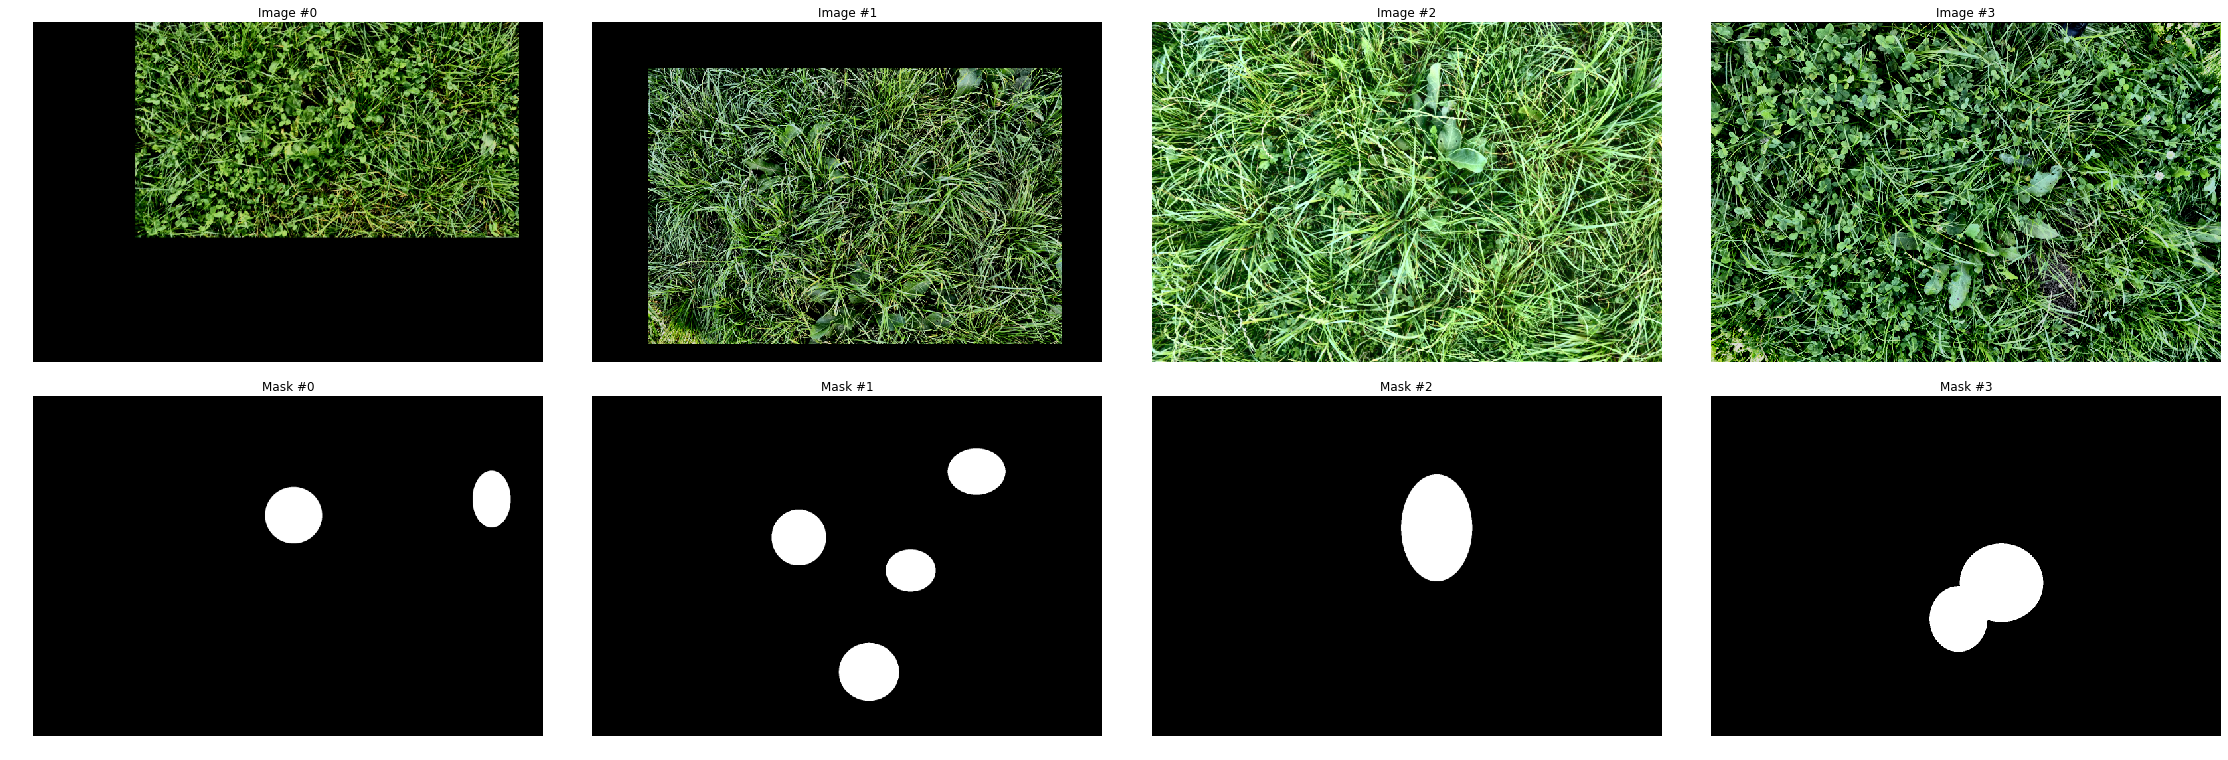

In [10]:
imgs,msks = next(i_sample)
plt.figure(figsize=(40,20))
x,y =4,1
for i in range(y):
    for j in range(x):
        plt.subplot(y*3,x,i*2*x+j+1)
        pos = i+j
        plt.imshow(imgs[pos,:,:,:].reshape(*Config.SHAPE,3))
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+1)*x+j+1)
        plt.imshow(msks[pos,:,:,0].reshape(Config.SHAPE),cmap='gray')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        if params['output'] == "both":
            plt.subplot(y*3,x,(i*2+2)*x+j+1)
            plt.imshow(msks[pos,:,:,1].reshape(Config.SHAPE),cmap='gray')
            plt.title('Mask_Circle #{}'.format(pos))
            plt.axis('off')
        
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.show()

In [11]:
print(imgs.shape)
print(msks.shape)
print(imgs.max())
print(msks.max())

(4, 512, 768, 3)
(4, 512, 768, 1)
1.0
1.0


### 3.5 Train:

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

BS = 2
import math
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.1
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    print("Learning Rate: " + str(lrate))
    return lrate

lrate = LearningRateScheduler(step_decay)


checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_dice_coeff', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coeff', 
                                   factor=0.1, 
                                   patience=6, 
                                   verbose=1, 
                                   mode='max', 
                                   epsilon=0.0001, 
                                   cooldown=6, 
                                   min_lr=0.0001)

early = EarlyStopping(monitor="val_dice_coeff", 
                      mode="max", 
                      patience=18,
                      restore_best_weights=True)

tensorboard = TensorBoard(log_dir='../docs/tensorboard2', 
                            histogram_freq=0, 
                            batch_size=BS*4, 
                            write_graph=True, 
                            write_grads=True, 
                            write_images=True, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None, 
                            embeddings_data=None, 
                            update_freq='epoch')

callbacks_list = [early,checkpoint,lrate,tensorboard]

In [13]:
params = {'target_size': Config.SHAPE,
          'batch_size': BS,
          'input_channels': 3,
          'shuffle': True,
          'output':"root"}

# Generators
training_generator = DataGenerator(df=train80_df,hist_equal=True,augment_data=True,save_images=False,**params)
validation_generator = DataGenerator(df=val20_df,hist_equal=True,**params)

Found 405 Files
Found 102 Files


In [14]:
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(train80_df)*1 // BS,
    validation_data=validation_generator,
    validation_steps=len(val20_df) // BS,
    epochs=2,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list)

Epoch 1/2
Learning Rate: 0.0001
202/202 [==============================] - 161s 797ms/step - loss: 1.2920 - dice_coeff: 0.2033 - iou_score: 0.1087 - val_loss: 2.2546 - val_dice_coeff: 0.3154 - val_iou_score: 0.1850

Epoch 00001: val_dice_coeff improved from -inf to 0.31535, saving model to best_model.h5
Epoch 2/2
Learning Rate: 0.0001
202/202 [==============================] - 149s 739ms/step - loss: 0.9525 - dice_coeff: 0.3268 - iou_score: 0.1826 - val_loss: 0.7915 - val_dice_coeff: 0.4071 - val_iou_score: 0.2476

Epoch 00002: val_dice_coeff improved from 0.31535 to 0.40709, saving model to best_model.h5


In [15]:
unet.unfreeze_encoder(model,"vgg19")
model = unet.get_model()

In [16]:
%%time
H2 = model.fit_generator(
    training_generator,
    steps_per_epoch=len(train80_df)*1 // BS,
    validation_data=validation_generator,
    validation_steps=len(val20_df) // BS,
    epochs=50,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list)

Epoch 1/50
Learning Rate: 0.0001
201/202 [============================>.] - ETA: 0s - loss: 0.8892 - dice_coeff: 0.3512 - iou_score: 0.1874Epoch 1/50
Epoch 1/50
202/202 [==============================] - 202s 998ms/step - loss: 0.8892 - dice_coeff: 0.3511 - iou_score: 0.1871 - val_loss: 1.1324 - val_dice_coeff: 0.3846 - val_iou_score: 0.2252

Epoch 00001: val_dice_coeff did not improve from 0.40709
Epoch 2/50
Learning Rate: 0.0001
202/202 [==============================] - 193s 956ms/step - loss: 0.8067 - dice_coeff: 0.3968 - iou_score: 0.2257 - val_loss: 1.1643 - val_dice_coeff: 0.0829 - val_iou_score: 0.0414

Epoch 00002: val_dice_coeff did not improve from 0.40709
Epoch 3/50
Learning Rate: 0.0001
201/202 [============================>.] - ETA: 0s - loss: 0.7196 - dice_coeff: 0.4618 - iou_score: 0.2774Learning Rate: 0.0001

Epoch 00002: val_dice_coeff did not improve from 0.40709
202/202 [==============================] - 194s 958ms/step - loss: 0.7197 - dice_coeff: 0.4616 - iou_scor

202/202 [==============================] - 193s 957ms/step - loss: 0.3347 - dice_coeff: 0.7491 - iou_score: 0.5944 - val_loss: 0.3780 - val_dice_coeff: 0.7167 - val_iou_score: 0.5590

Epoch 00025: val_dice_coeff improved from 0.70769 to 0.71672, saving model to best_model.h5
Epoch 26/50
Learning Rate: 1e-05
202/202 [==============================] - 194s 959ms/step - loss: 0.3322 - dice_coeff: 0.7510 - iou_score: 0.5971 - val_loss: 0.3907 - val_dice_coeff: 0.7071 - val_iou_score: 0.5543

Epoch 00026: val_dice_coeff did not improve from 0.71672
Epoch 27/50
Learning Rate: 1e-05
202/202 [==============================] - 194s 959ms/step - loss: 0.3237 - dice_coeff: 0.7594 - iou_score: 0.6078 - val_loss: 0.3943 - val_dice_coeff: 0.7034 - val_iou_score: 0.5430

Epoch 00027: val_dice_coeff did not improve from 0.71672
Epoch 28/50
Learning Rate: 1e-05
202/202 [==============================] - 194s 962ms/step - loss: 0.3227 - dice_coeff: 0.7578 - iou_score: 0.6083 - val_loss: 0.3815 - val_dic


Epoch 00046: val_dice_coeff did not improve from 0.73501
Epoch 47/50
Learning Rate: 1.0000000000000002e-06
201/202 [============================>.] - ETA: 0s - loss: 0.2809 - dice_coeff: 0.7918 - iou_score: 0.6543
Epoch 00046: val_dice_coeff did not improve from 0.73501
Epoch 47/50
Learning Rate: 1.0000000000000002e-06
202/202 [==============================] - 193s 956ms/step - loss: 0.2815 - dice_coeff: 0.7913 - iou_score: 0.6534 - val_loss: 0.3621 - val_dice_coeff: 0.7352 - val_iou_score: 0.5803

Epoch 00047: val_dice_coeff improved from 0.73501 to 0.73519, saving model to best_model.h5
Epoch 48/50
Learning Rate: 1.0000000000000002e-06
202/202 [==============================] - 194s 962ms/step - loss: 0.2858 - dice_coeff: 0.7880 - iou_score: 0.6461 - val_loss: 0.3645 - val_dice_coeff: 0.7333 - val_iou_score: 0.5783

Epoch 00048: val_dice_coeff did not improve from 0.73519
Epoch 49/50
Learning Rate: 1.0000000000000002e-06
202/202 [==============================] - 195s 966ms/step - 

In [17]:
model.load_weights("best_model.h5")

### Training Stats

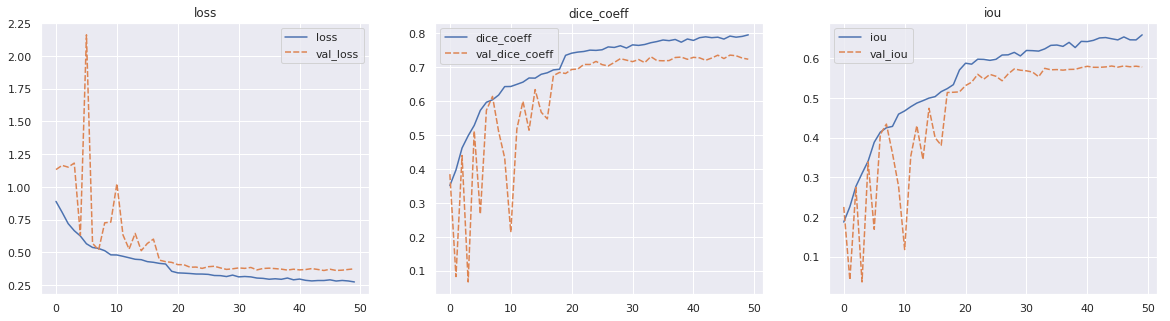

In [19]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "loss":H2.history['loss'],
        "val_loss":H2.history['val_loss']}
loss_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=loss_data).set_title("loss")

plt.subplot(1,3,2)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "dice_coeff":H2.history['dice_coeff'],
        "val_dice_coeff":H2.history['val_dice_coeff']}
dice_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=dice_data).set_title("dice_coeff")

plt.subplot(1,3,3)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "iou":H2.history['iou_score'],
        "val_iou":H2.history['val_iou_score']}
iou_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=iou_data).set_title("iou")

In [20]:
model.save('model2.h5')

In [21]:
loss_data.to_pickle("loss_data_df_model2.h5")
dice_data.to_pickle("dice_data_df_model2.h5")
iou_data.to_pickle("iou_data_df_model2.h5")

In [33]:
vis_params = {'df':val20_df,
              'input_shape':(512,768,3),
              'masktype':'leaf',
              'model':model}

visualize = Visualize(**vis_params)

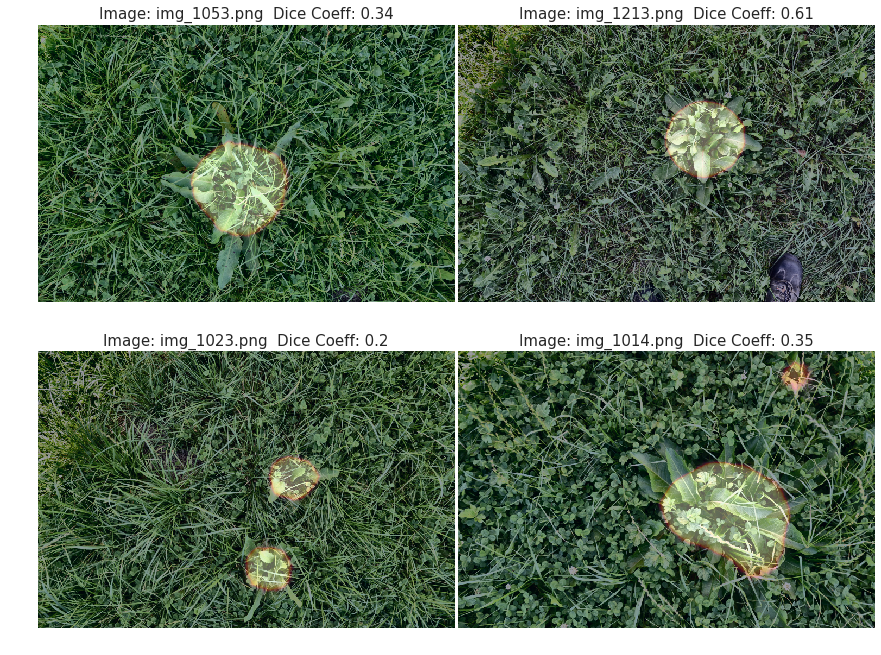

In [35]:
visualize.show_matrix(index='random',mode='image_prediction',rows=2)

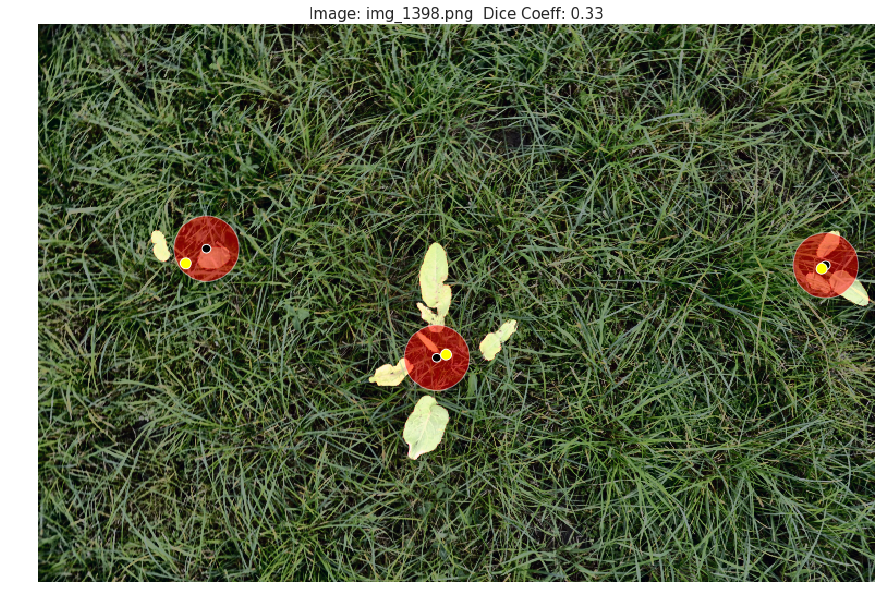

In [36]:
vis_params = {'df':val20_df,
              'input_shape':(512,768,3),
              'masktype':'root',
              'model':model}

root_pred = Visualize(**vis_params)
#img_1114
root_pred.show_single("1398",mode="image_prediction_roots")

### 3.7 Visualize Error Mask

In [40]:
ev_params = {'df':val20_df,
             'input_shape':(512,768,3),
             'pred_layer' : 1,
             'model':model}
ev = Evaluate(**ev_params)

Aufsummiern aller falsch detektieren Masken (False Positive + False Negative):

In [41]:
def predict_all_error(df):
    error_sum = np.zeros(SHAPE)
    for i, row in df.iterrows():
        err = ev.get_full_error_mask(index=row['name'])
        error_sum += err
    return error_sum

In [79]:
summed_mask_error = predict_all_error(val_df)

Visualisierung aller überlagerten False Positiv + False Negativ Masken:

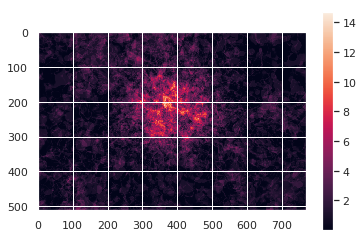

In [81]:
imshow(summed_mask_error)
plt.colorbar()

In [83]:
summed_mask_train = np.zeros((1024,1536))
for i,row in val_df.iterrows():
    summed_mask_train += rle_decode(row['mask_rle'],(1024,1536))
summed_mask_train = resize(summed_mask_train,(512,768))

Vergleich der summierten Trainingsmasken (Bild rechts) mit den summierten Falschen vorhersagen (Bild mitte). Das Bild rechts zeigt die subtraktion der normalisierten Trainingsmasken mit den normalisierten False Positiv + False Negativ:

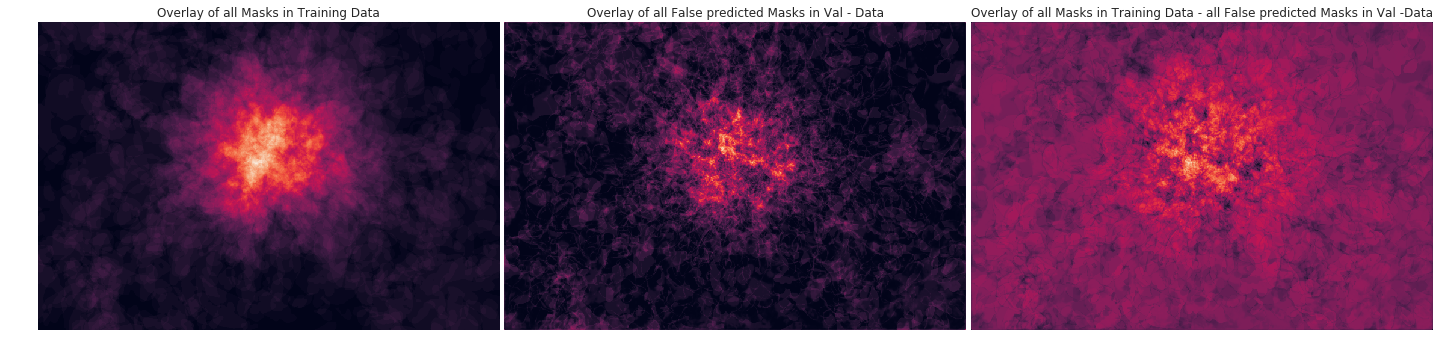

In [84]:
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(25,18))
axs[0].imshow(summed_mask_train)
axs[1].imshow(summed_mask_error)
#axs[1,0].imshow(summed_mask_train-summed_mask_error)
axs[2].imshow(summed_mask_train/summed_mask_train.max()-summed_mask_error/summed_mask_error.max())
axs[0].set_title('Overlay of all Masks in Training Data')
axs[0].axis('off')
axs[1].set_title('Overlay of all False predicted Masks in Val - Data')
axs[1].axis('off')
axs[2].set_title('Overlay of all Masks in Training Data - all False predicted Masks in Val -Data')
axs[2].axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0)

Die meisten falsch vohergesagten Masken befinden sich zwar im Zentrum der Bilder (wie die meisten Masken in den Trainingsbildern), jedoch sind diese besser Verteilt als die Ground Truth Masken. (Die Farbskalierung der Bilder ist bei beiden gleich) 
Daraus schliesse ich, das sich die Anhäufung der GroundTruth- Masken in den Trainingsdaten im Zentrum, negativ auf die vorhersagen von Blacken im Randbereich asuwirkt. d.h. es werden im Randbereich der Bilder überdurchschnittlich viele Blacken falsch vorhergesagt.